# [1] Knn Assignment


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import log_loss
from tqdm import tqdm
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize


In [2]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [3]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')

In [4]:
encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_train = np.ravel(encoded_column_vector)

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_test = np.ravel(encoded_column_vector)

encoded_column = label_binarize(y_cv, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_cv = np.ravel(encoded_column)

In [5]:
def drawplots(alpha,auc_cv,auc_train):
    fig, ax = plt.subplots(figsize=(10,10))
    a = np.arange(len(alpha))
    ax.plot(a, auc_cv,c='g',label="cv")
#     for i, txt in enumerate(np.round(cv_log_error_array,3)):
#         ax[0].annotate((a[i],str(txt)), (a[i],cv_log_error_array[i]))
    
    ax.plot(a, auc_train,c='r',label="train")
#     for i, txt in enumerate(np.round(train_log_error_array,3)):
#         ax[0].annotate((a[i],str(txt)), (a[i],train_log_error_array[i]),(a[i]+0.005,train_log_error_array[i]+0.015))
        
    ax.set_xticks(a)
    ax.set_xticklabels(alpha)
    plt.grid()
    ax.set_title("Cross Validation AUC for each K")
    ax.set_xlabel("K i's")
    ax.set_ylabel("AUC")
    
    plt.legend(loc="best")
    plt.show()    

In [6]:
def calculateAUC(k,X_train,X_cv,Y,algo):
    auc_array = []
    for i in k :
        # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=i,algorithm = algo)

        # fitting the model on crossvalidation train

        knn.fit(X_train, y_train)

        # predict the response on the crossvalidation train
        # pred = knn.predict(X_cv)
        pred = []
        if(isinstance(X_cv,list)):
            range_size = len(X_cv)
        else:
            range_size = X_cv.shape[0]
        for j in range(0,range_size, 1000):
            pred.append(knn.predict(X_cv[j:j+1000]))

        # evaluate CV logloss
        pred =[y for x in pred for y in x]
        area = roc_auc_score(Y, pred)
        auc_array.append(area)
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("For k = {} AUC:{}  ".format(i,area))
    return auc_array

In [7]:
def performCrossValidation(X_train,X_cv,algo):
    k = list(range(1,60,10))
    
    #calucate auc for cv and train
    auc_cv = calculateAUC(k,X_train,X_cv,y_cv,algo)
    auc_train = calculateAUC(k,X_train,X_train,y_train,algo)
    
    #drawing auc plots for cv and train
    drawplots(k,auc_cv,auc_train)
    
    optimal_k = np.argmax(auc_cv)
    return k[optimal_k]

In [8]:
def kNNAlgorithm(X_train,X_test,optimal_k,algo='kd_tree'):
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm=algo)
    knn_optimal.fit(X_train, y_train)
    #pred = knn_optimal.predict(X_test)
    pred = []
    if(isinstance(X_test,list)):
        range_size = len(X_test)
    else:
        range_size = X_test.shape[0]
    for i in range(0, range_size, 1000):
        pred.append(knn_optimal.predict(X_test[i:i+1000]))
    pred =[y for x in pred for y in x]
    area = roc_auc_score(y_test, pred)

    print("For k = {} AUC:{}  ".format(optimal_k,area))   

In [9]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [10]:
# plot the graph to find the best n_components using elbow knee method
def findNumberOfComponents(cv):
    trun_svd = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
    trun_svd.fit(cv)
    explained_variance = trun_svd.explained_variance_ratio_
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(explained_variance,'k--')
    return explained_variance

In [11]:
# apply truncatedSVD on given data and return the truncateddata
def applyTruncatedSVD(train,test,cv,n_component):
    trun_svd = TruncatedSVD(n_components=n_component, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
    train = trun_svd.fit_transform(train)
    test = trun_svd.transform(test)
    cv = trun_svd.transform(cv)
    return train,test,cv

In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    labels = [0,1]
    C = confusion_matrix(test_y, predict_y)
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


# BOW

In [17]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

For k = 1 AUC:0.5079576284903224  
For k = 11 AUC:0.5029883093641597  
For k = 21 AUC:0.4999321527919126  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9997380776445265  
For k = 11 AUC:0.5165267951709325  
For k = 21 AUC:0.5000859126364203  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


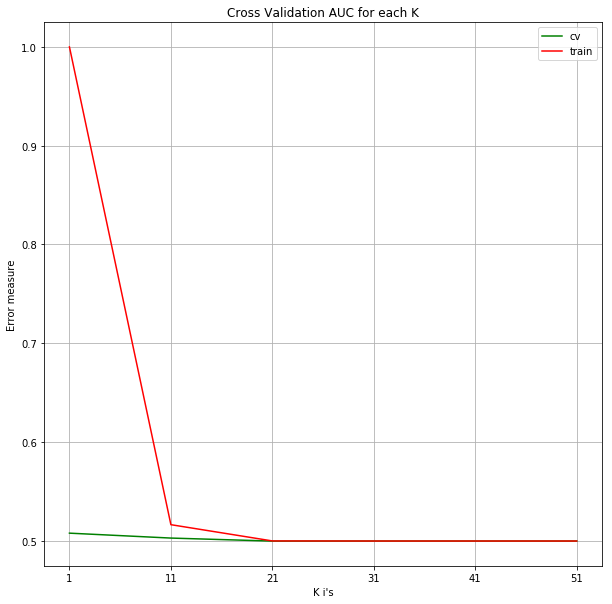

In [23]:
optimal_k = performCrossValidation(train,cv,'brute')

In [24]:
print(optimal_k)

1


In [25]:
kNNAlgorithm(train,test,optimal_k,'brute')

For k = 1 AUC:0.49785056942892136  


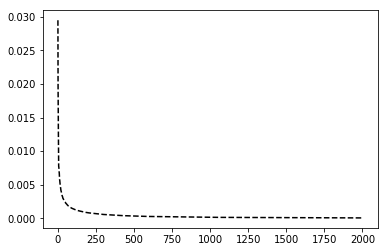

In [18]:
explained_variance = findNumberOfComponents(cv)

In [19]:
no_of_components = select_n_components(explained_variance,0.7)

In [20]:
print(no_of_components)

839


In [21]:
train.shape

(69920, 46483)

In [22]:
train,test,cv = applyTruncatedSVD(train,test,cv,no_of_components)

In [23]:
cv.shape

(17480, 839)

For k = 1 AUC:0.6130109608266161  
For k = 11 AUC:0.5666479511343665  
For k = 21 AUC:0.5486126236054967  
For k = 31 AUC:0.5373278705068335  
For k = 41 AUC:0.5303577023128373  
For k = 51 AUC:0.5248257290870635  
For k = 1 AUC:1.0  
For k = 11 AUC:0.5934244250920897  
For k = 21 AUC:0.5548952548418626  
For k = 31 AUC:0.5386890957624437  
For k = 41 AUC:0.5302413756417199  
For k = 51 AUC:0.5249984076287173  


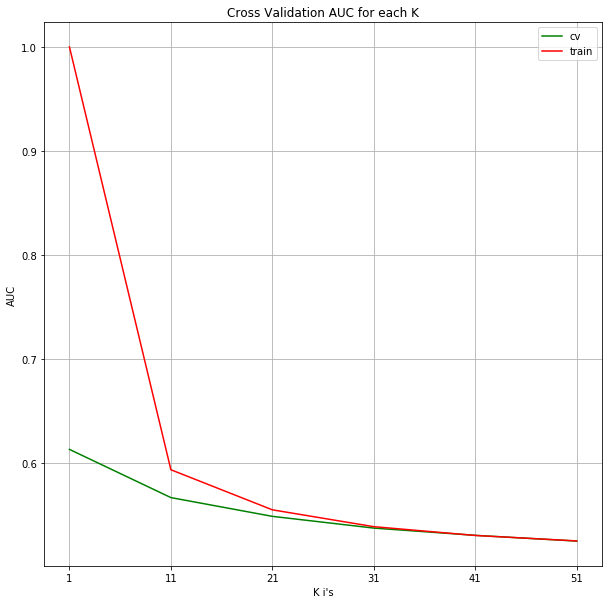

In [24]:
optimal_k = performCrossValidation(train,cv,'kd_tree')

In [25]:
kNNAlgorithm(train,test,optimal_k,'kd_tree')

For k = 1 AUC:0.6112935453192136  


# Tf-Idf

In [26]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

For k = 1 AUC:0.4989873661864812  
For k = 11 AUC:0.5004755368982746  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9997667151899998  
For k = 11 AUC:0.5032090487063738  
For k = 21 AUC:0.500173917495947  
For k = 31 AUC:0.5000455996352029  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


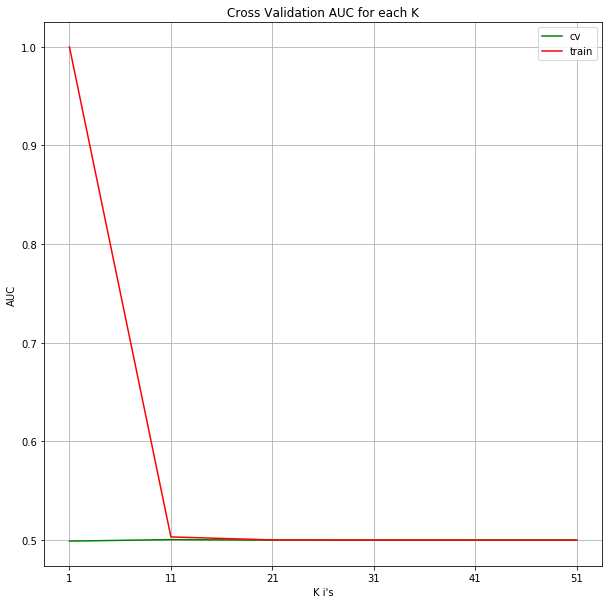

In [27]:
optimal_k = performCrossValidation(train,cv,'brute')

In [29]:
kNNAlgorithm(train,test,optimal_k,'brute')

For k = 11 AUC:0.49962354516336704  


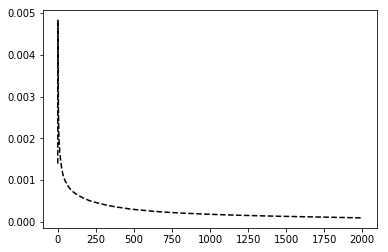

In [30]:
explained_variance = findNumberOfComponents(cv)

In [38]:
n_components = select_n_components(explained_variance, 0.7)
print(n_components)

2000


In [40]:
train,test,cv = applyTruncatedSVD(train,test,cv,no_of_components)

For k = 1 AUC:0.49278126498235786  
For k = 11 AUC:0.49997054426208537  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.99966384046385  
For k = 11 AUC:0.5014327551565662  
For k = 21 AUC:0.5000371185903382  
For k = 31 AUC:0.4999915189551353  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


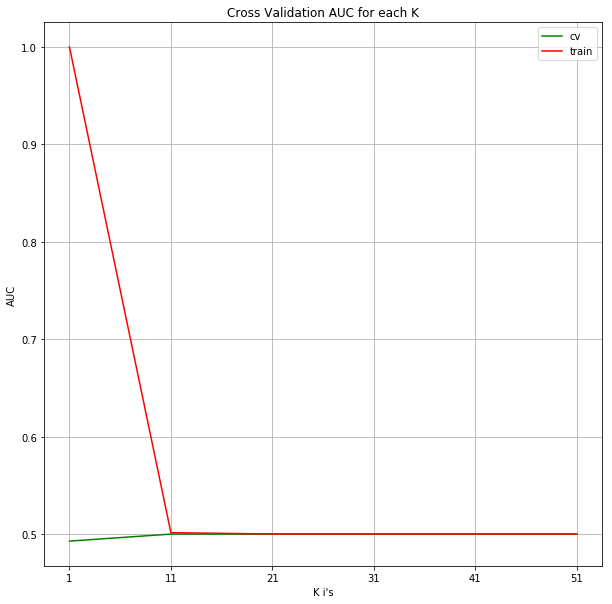

In [41]:
optimal_k = performCrossValidation(train,cv,'kd_tree')

In [42]:
kNNAlgorithm(train,test,optimal_k)

For k = 21 AUC:0.5001459002042603  


# Avg W2V

In [43]:
train = loadPickleData("avg_w2v_train.pickle")
test = loadPickleData('avg_w2v_test.pickle')
cv = loadPickleData('avg_w2v_cv.pickle')

In [44]:
isinstance(cv,list)

True

For k = 1 AUC:0.49791426147571416  
For k = 11 AUC:0.499466158067559  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9996214352395264  
For k = 11 AUC:0.5047309109102397  
For k = 21 AUC:0.5000742371806763  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


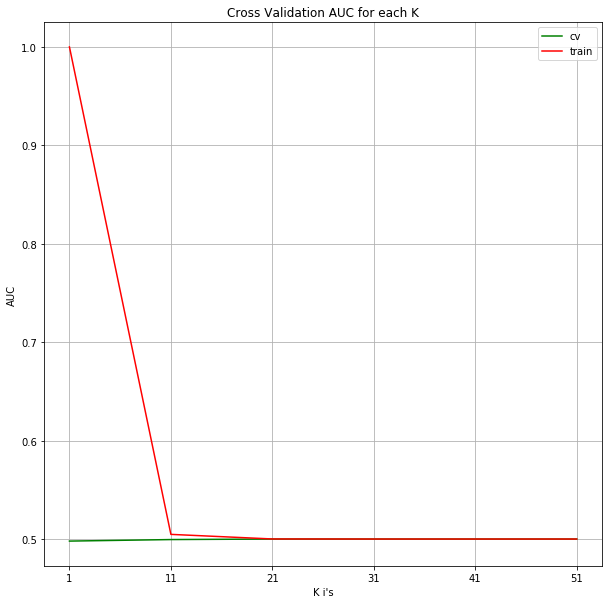

In [45]:
optimal_k = performCrossValidation(train,cv,'brute')

In [46]:
kNNAlgorithm(train,test,optimal_k,'brute')

For k = 21 AUC:0.5001187616892798  


For k = 1 AUC:0.49791426147571416  
For k = 11 AUC:0.499466158067559  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9996214352395264  
For k = 11 AUC:0.5047309109102397  
For k = 21 AUC:0.5000742371806763  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


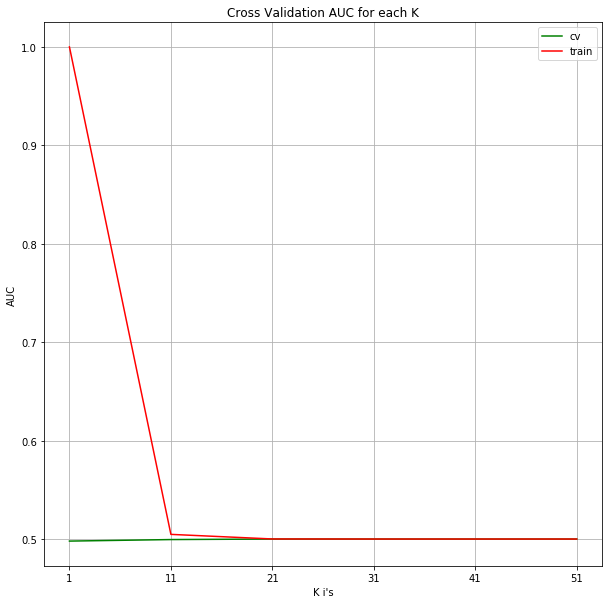

In [47]:
optimal_k = performCrossValidation(train,cv,'kd_tree')

In [48]:
kNNAlgorithm(train,test,optimal_k,'kd_tree')

For k = 21 AUC:0.5001187616892798  


# Tfidf W2V

In [49]:
train = loadPickleData("tfidf_w2v_train.pickle")
test = loadPickleData('tfidf_w2v_test.pickle')
cv = loadPickleData('tfidf_w2v_cv.pickle')

For k = 1 AUC:0.4981446102967507  
For k = 11 AUC:0.4992837428906163  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9996214352395264  
For k = 11 AUC:0.504640813827607  
For k = 21 AUC:0.5000742371806763  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


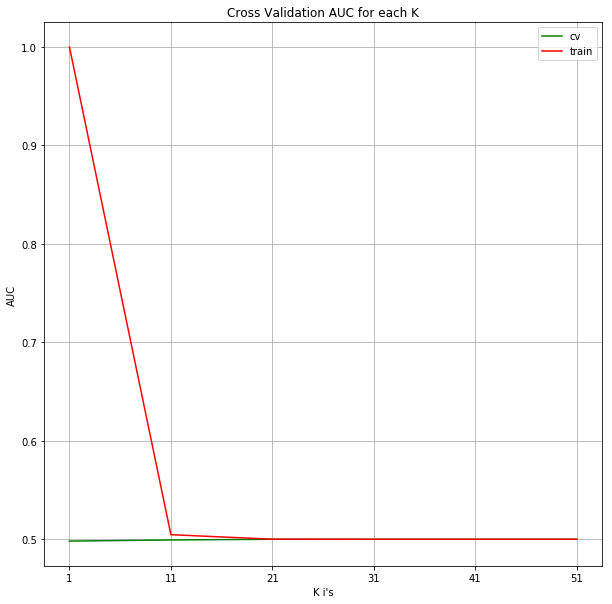

In [50]:
optimal_k = performCrossValidation(train,cv,'brute')

In [51]:
kNNAlgorithm(train,test,optimal_k,'brute')

For k = 21 AUC:0.4999457229700391  


For k = 1 AUC:0.49824638110888175  
For k = 11 AUC:0.4992837428906163  
For k = 21 AUC:0.5  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  
For k = 1 AUC:0.9995641601485795  
For k = 11 AUC:0.504640813827607  
For k = 21 AUC:0.5000742371806763  
For k = 31 AUC:0.5  
For k = 41 AUC:0.5  
For k = 51 AUC:0.5  


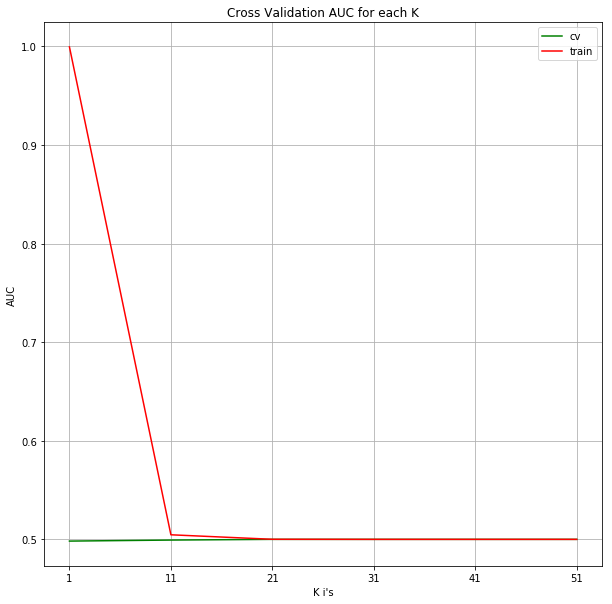

In [52]:
optimal_k = performCrossValidation(train,cv,'kd_tree')

In [53]:
kNNAlgorithm(train,test,optimal_k,'kd_tree')

For k = 21 AUC:0.4999457229700391  


### Summary

| Vectorizer |  Model | HyperParameter | LogLoss |
|------------|--------|----------------|---------|
| BOW        | Brute  | 1              | 0.497   |
| BOW        | kdtree | 1              | 0.61    |
| TFIDF      | Brute  | 11             | 0.499   |
| TFIDF      | kdtree | 21             | 0.5     |
| AvgW2V     | Brute  | 21             | 0.5     |
| AvgW2V     | kdtree | 21             | 0.500   |
| TFIDFW2V   | Brute  | 21             | 0.499   |
| TFIDFW2V   | kdtree | 21             | 0.499   |